# Improving Bank Marketing Efficiency Through Predictive Analytics
**Author:** Manish Katragadda | Harrisburg University  
**Dataset:** UCI Bank Marketing Dataset (Moro et al., 2014)  
**Methodology:** CRISP-DM Framework

---

## Notebook Overview

This notebook implements the full analysis pipeline described in the final project report:

1. Data Loading & Initial Screening
2. Exploratory Data Analysis (EDA)
3. Data Preparation & Preprocessing
4. Model Training (Logistic Regression, Random Forest, XGBoost, SVM)
5. Model Evaluation (Accuracy, Recall, F1, ROC-AUC)
6. Feature Importance Analysis
7. Results Summary

**Research Question:** Can predictive analytics models accurately predict customer subscription to a bank term deposit using historical marketing and customer data?

---

## 0. Install & Import Libraries

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, recall_score, f1_score,
    roc_auc_score, classification_report,
    ConfusionMatrixDisplay, RocCurveDisplay
)
from xgboost import XGBClassifier

# Plot styling
sns.set_theme(style='whitegrid', palette='muted')
plt.rcParams['figure.dpi'] = 120
plt.rcParams['font.family'] = 'DejaVu Sans'

NAVY  = '#0A2342'
TEAL  = '#1A7FA8'
AMBER = '#E8A838'
LIGHT = '#F0F4F8'

print('All libraries imported successfully.')

All libraries imported successfully.


---
## 1. Data Loading & Initial Screening

The dataset is downloaded directly from the UCI Machine Learning Repository.  
It contains **45,211 observations** from direct marketing campaigns of a Portuguese bank

In [11]:
#  Load data from UCI
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank.zip'

import urllib.request, zipfile, io
with urllib.request.urlopen(url) as response:
    z = zipfile.ZipFile(io.BytesIO(response.read()))
    df = pd.read_csv(z.open('bank-full.csv'), sep=';')

print(f'Dataset loaded: {df.shape[0]:,} rows × {df.shape[1]} columns')
df.head()

Dataset loaded: 45,211 rows × 17 columns


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [12]:
#Data Screening
print('=' * 55)
print('DATA SCREENING SUMMARY')
print('=' * 55)

print(f'\nShape          : {df.shape[0]:,} rows × {df.shape[1]} columns')
print(f'Missing values : {df.isnull().sum().sum()} (none — consistent with documentation)')
print(f'Duplicate rows : {df.duplicated().sum()}')

print('\n── Column Data Types ──')
print(df.dtypes.to_string())

print('\n── Numeric Summary ──')
df.describe().round(2)

DATA SCREENING SUMMARY

Shape          : 45,211 rows × 17 columns
Missing values : 0 (none — consistent with documentation)
Duplicate rows : 0

── Column Data Types ──
age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object

── Numeric Summary ──


,age,balance,day,duration,campaign,pdays,previous
count,45211.00,45211.00,45211.00,45211.00,45211.00,45211.00,45211.00
mean,40.94,1362.27,15.81,258.16,2.76,40.20,0.58
std,10.62,3044.77,8.32,257.53,3.10,100.13,2.30
min,18.00,-8019.00,1.00,0.00,1.00,-1.00,0.00
25%,33.00,72.00,8.00,103.00,1.00,-1.00,0.00
50%,39.00,448.00,16.00,180.00,2.00,-1.00,0.00
75%,48.00,1428.00,21.00,319.00,3.00,-1.00,0.00
max,95.00,102127.00,31.00,4918.00,63.00,871.00,275.00


In [13]:
counts = df['y'].value_counts()
pcts   = df['y'].value_counts(normalize=True) * 100

print('Target Variable Distribution')
print('─' * 35)
for cls in counts.index:
    print(f"  {cls:>4s}  →  {counts[cls]:6,}  ({pcts[cls]:.1f}%)")

print(f"\nClass imbalance ratio  : {counts['no'] / counts['yes']:.1f} : 1  (no : yes)")
print("\nImplication: Accuracy alone is misleading.")
print("A model predicting 'no' for every record would achieve ~88.3% accuracy.")
print("→ Recall and ROC-AUC will be the primary evaluation metrics.")

Target Variable Distribution
───────────────────────────────────
    no  →  39,922  (88.3%)
   yes  →   5,289  (11.7%)

Class imbalance ratio  : 7.5 : 1  (no : yes)

Implication: Accuracy alone is misleading.
A model predicting 'no' for every record would achieve ~88.3% accuracy.
→ Recall and ROC-AUC will be the primary evaluation metrics.


---
## 2. Exploratory Data Analysis (EDA)

The EDA follows the CRISP-DM Data Understanding phase.  


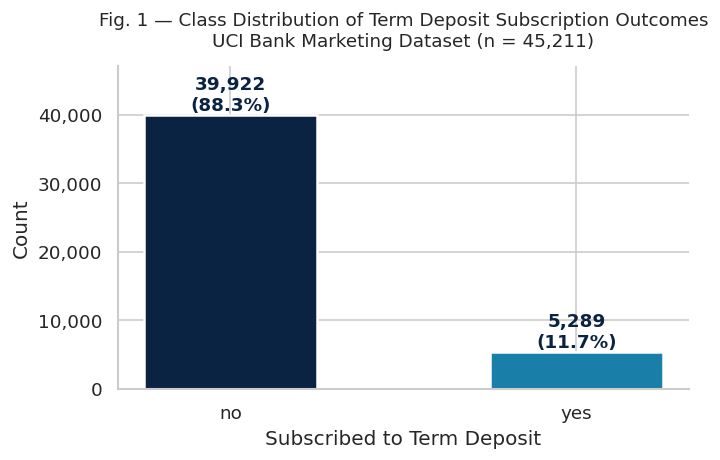

Fig. 1 saved as fig1_class_distribution.png


In [14]:
# Fig. 1: Class Distribution (matches report Figure 1)
fig, ax = plt.subplots(figsize=(6, 4))

bars = ax.bar(
    counts.index, counts.values,
    color=[NAVY, TEAL], edgecolor='white', linewidth=1.5, width=0.5
)

for bar, (cls, cnt, pct) in zip(bars, zip(counts.index, counts.values, pcts.values)):
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 200,
        f'{cnt:,}\n({pct:.1f}%)',
        ha='center', va='bottom', fontsize=11, fontweight='bold', color=NAVY
    )

ax.set_xlabel('Subscribed to Term Deposit', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title(
    'Fig. 1 — Class Distribution of Term Deposit Subscription Outcomes\n'
    'UCI Bank Marketing Dataset (n = 45,211)',
    fontsize=11, pad=12
)
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
ax.set_ylim(0, counts.max() * 1.18)
sns.despine()
plt.tight_layout()
plt.savefig('fig1_class_distribution.png', bbox_inches='tight')
plt.show()
print('Fig. 1 saved as fig1_class_distribution.png')

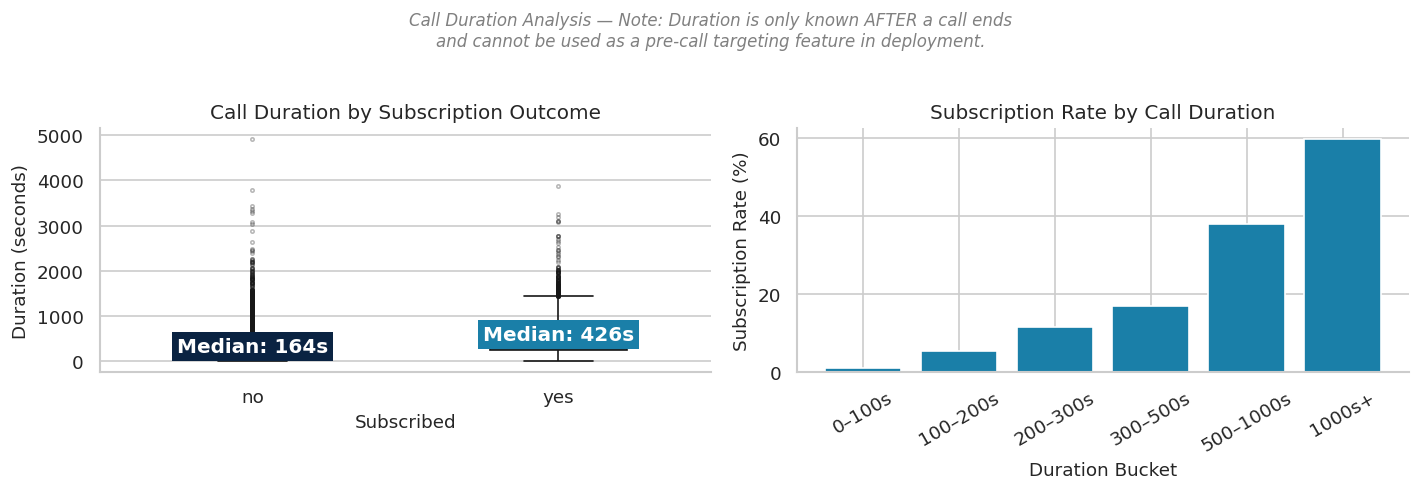

Median duration — No: 164s  |  Yes: 426s
Ratio: 2.6× longer for subscribers


In [15]:
# Call Duration vs Subscription
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Boxplot
sns.boxplot(
    data=df, x='y', y='duration',
    palette={'no': NAVY, 'yes': TEAL},
    width=0.45, flierprops=dict(marker='o', markersize=2, alpha=0.3),
    ax=axes[0]
)
axes[0].set_title('Call Duration by Subscription Outcome', fontsize=12)
axes[0].set_xlabel('Subscribed', fontsize=11)
axes[0].set_ylabel('Duration (seconds)', fontsize=11)

# Median comparison annotation
med_no  = df[df['y'] == 'no']['duration'].median()
med_yes = df[df['y'] == 'yes']['duration'].median()
axes[0].text(0, med_no + 50, f'Median: {med_no:.0f}s', ha='center', color='white',
             fontweight='bold', bbox=dict(facecolor=NAVY, edgecolor='none', pad=3))
axes[0].text(1, med_yes + 50, f'Median: {med_yes:.0f}s', ha='center', color='white',
             fontweight='bold', bbox=dict(facecolor=TEAL, edgecolor='none', pad=3))

# Subscription rate by duration bucket
df['duration_bucket'] = pd.cut(
    df['duration'],
    bins=[0, 100, 200, 300, 500, 1000, df['duration'].max()],
    labels=['0–100s', '100–200s', '200–300s', '300–500s', '500–1000s', '1000s+']
)
rate_by_dur = df.groupby('duration_bucket', observed=True)['y'].apply(
    lambda x: (x == 'yes').mean() * 100
).reset_index()
rate_by_dur.columns = ['duration_bucket', 'subscription_rate']

axes[1].bar(
    rate_by_dur['duration_bucket'].astype(str),
    rate_by_dur['subscription_rate'],
    color=TEAL, edgecolor='white'
)
axes[1].set_title('Subscription Rate by Call Duration', fontsize=12)
axes[1].set_xlabel('Duration Bucket', fontsize=11)
axes[1].set_ylabel('Subscription Rate (%)', fontsize=11)
axes[1].tick_params(axis='x', rotation=30)

sns.despine()
plt.suptitle(
    'Call Duration Analysis — Note: Duration is only known AFTER a call ends\n'
    'and cannot be used as a pre-call targeting feature in deployment.',
    fontsize=10, style='italic', color='gray', y=1.02
)
plt.tight_layout()
plt.show()
print(f'Median duration — No: {med_no:.0f}s  |  Yes: {med_yes:.0f}s')
print(f'Ratio: {med_yes / med_no:.1f}× longer for subscribers')

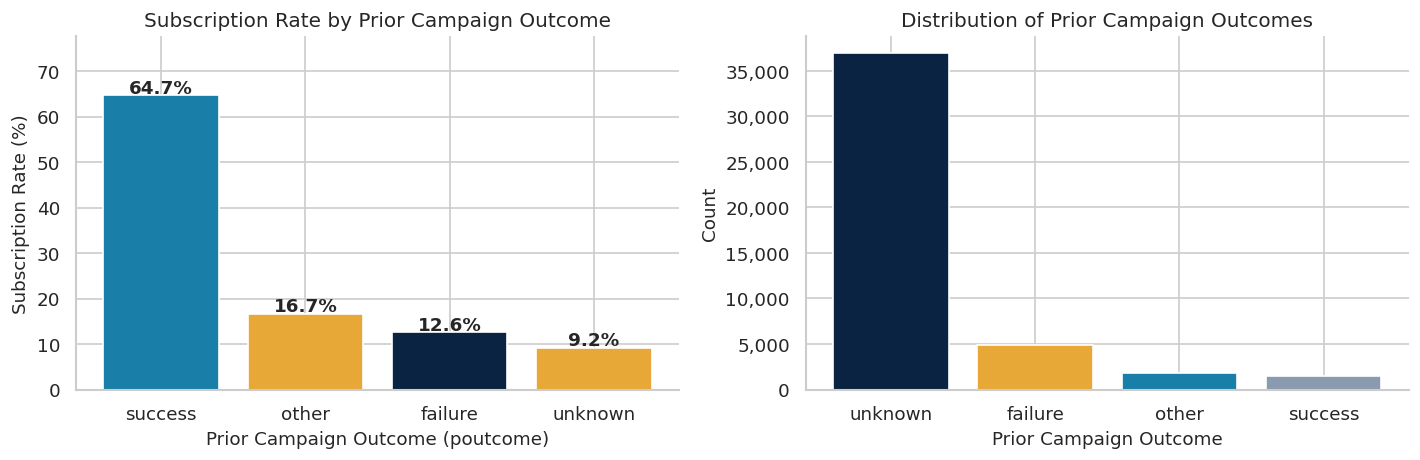

Prior campaign outcome — subscription rates:
poutcome  subscription_rate
 success          64.725347
   other          16.684783
 failure          12.609671
 unknown           9.161503


In [16]:
#  Prior Campaign Outcome (poutcome)
poutcome_rate = df.groupby('poutcome')['y'].apply(
    lambda x: (x == 'yes').mean() * 100
).sort_values(ascending=False).reset_index()
poutcome_rate.columns = ['poutcome', 'subscription_rate']
poutcome_counts = df['poutcome'].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

colors = [TEAL if v == 'success' else NAVY if v == 'failure' else AMBER
          for v in poutcome_rate['poutcome']]

bars = axes[0].bar(
    poutcome_rate['poutcome'], poutcome_rate['subscription_rate'],
    color=colors, edgecolor='white'
)
for bar, val in zip(bars, poutcome_rate['subscription_rate']):
    axes[0].text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5,
                 f'{val:.1f}%', ha='center', fontweight='bold', fontsize=11)
axes[0].set_title('Subscription Rate by Prior Campaign Outcome', fontsize=12)
axes[0].set_xlabel('Prior Campaign Outcome (poutcome)', fontsize=11)
axes[0].set_ylabel('Subscription Rate (%)', fontsize=11)
axes[0].set_ylim(0, poutcome_rate['subscription_rate'].max() * 1.2)

# Count distribution
axes[1].bar(
    poutcome_counts.index, poutcome_counts.values,
    color=[NAVY, AMBER, TEAL, '#8A9BB0'][:len(poutcome_counts)],
    edgecolor='white'
)
axes[1].set_title('Distribution of Prior Campaign Outcomes', fontsize=12)
axes[1].set_xlabel('Prior Campaign Outcome', fontsize=11)
axes[1].set_ylabel('Count', fontsize=11)
axes[1].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))

sns.despine()
plt.tight_layout()
plt.show()
print('Prior campaign outcome — subscription rates:')
print(poutcome_rate.to_string(index=False))

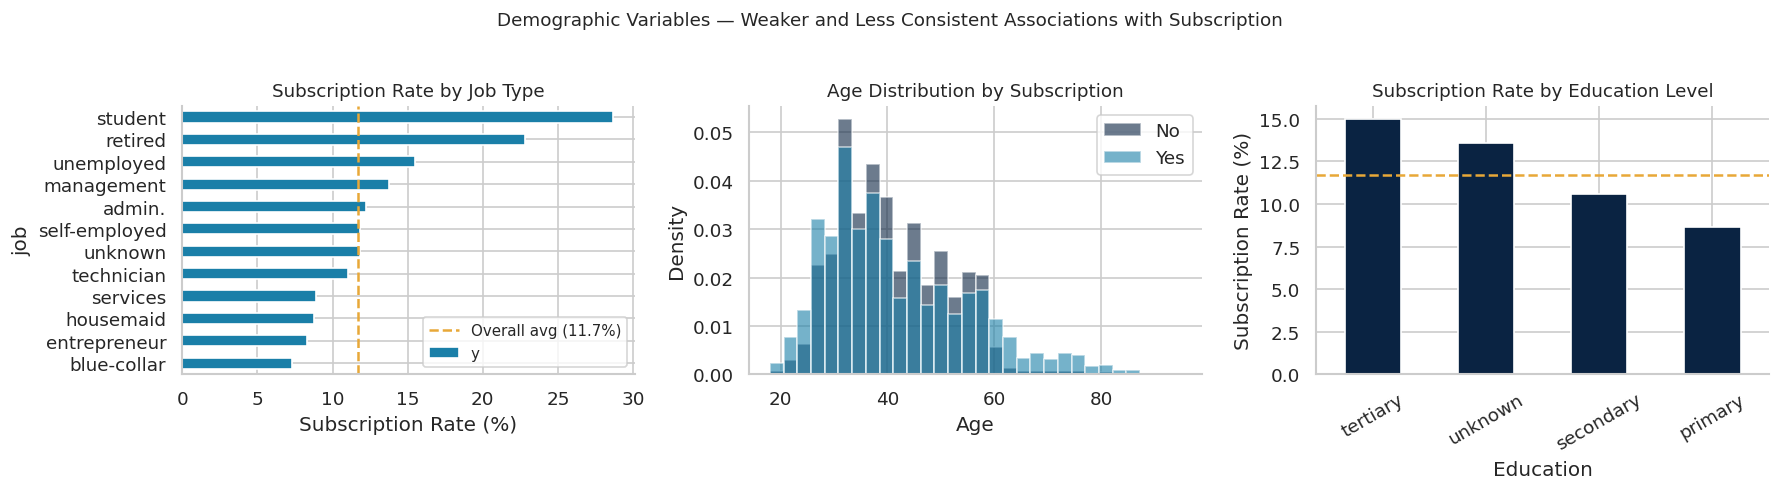

In [17]:
#  Demographic Variables
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Job type
job_rate = df.groupby('job')['y'].apply(
    lambda x: (x == 'yes').mean() * 100
).sort_values(ascending=True)
job_rate.plot(kind='barh', ax=axes[0], color=TEAL, edgecolor='white')
axes[0].set_title('Subscription Rate by Job Type', fontsize=11)
axes[0].set_xlabel('Subscription Rate (%)')
axes[0].axvline(pcts['yes'], color=AMBER, linestyle='--', linewidth=1.5,
                label=f'Overall avg ({pcts["yes"]:.1f}%)')
axes[0].legend(fontsize=9)

# Age distribution
df_yes = df[df['y'] == 'yes']['age']
df_no  = df[df['y'] == 'no']['age']
axes[1].hist(df_no,  bins=30, alpha=0.6, color=NAVY,  label='No',  density=True)
axes[1].hist(df_yes, bins=30, alpha=0.6, color=TEAL,  label='Yes', density=True)
axes[1].set_title('Age Distribution by Subscription', fontsize=11)
axes[1].set_xlabel('Age')
axes[1].set_ylabel('Density')
axes[1].legend()

# Education
edu_rate = df.groupby('education')['y'].apply(
    lambda x: (x == 'yes').mean() * 100
).sort_values(ascending=False)
edu_rate.plot(kind='bar', ax=axes[2], color=NAVY, edgecolor='white')
axes[2].set_title('Subscription Rate by Education Level', fontsize=11)
axes[2].set_xlabel('Education')
axes[2].set_ylabel('Subscription Rate (%)')
axes[2].tick_params(axis='x', rotation=30)
axes[2].axhline(pcts['yes'], color=AMBER, linestyle='--', linewidth=1.5)

sns.despine()
plt.suptitle(
    'Demographic Variables — Weaker and Less Consistent Associations with Subscription',
    fontsize=11, y=1.02
)
plt.tight_layout()
plt.show()

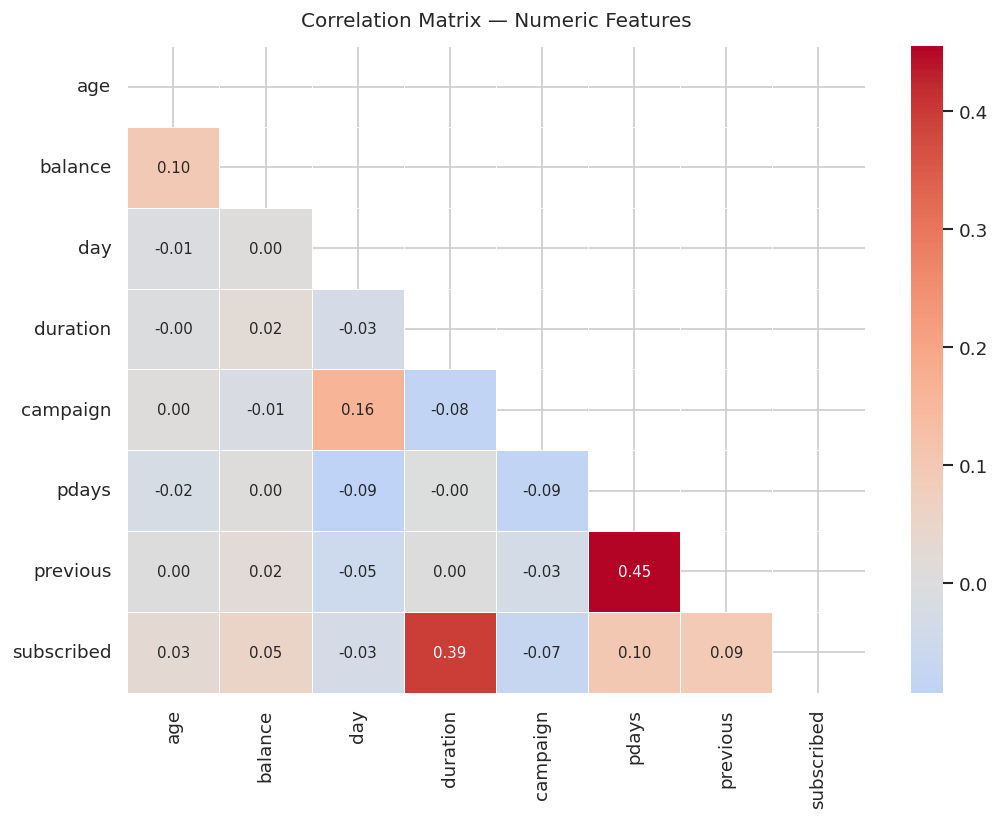


Correlation with target (subscribed):
duration    0.394521
pdays       0.103621
previous    0.093236
balance     0.052838
age         0.025155
day        -0.028348
campaign   -0.073172


In [18]:
#  Correlation Heatmap (numeric features)
numeric_cols = df.select_dtypes(include='number').columns.tolist()
df_corr = df[numeric_cols].copy()
df_corr['subscribed'] = (df['y'] == 'yes').astype(int)

fig, ax = plt.subplots(figsize=(9, 7))
corr_matrix = df_corr.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(
    corr_matrix, mask=mask, annot=True, fmt='.2f',
    cmap='coolwarm', center=0, linewidths=0.5,
    annot_kws={'size': 9}, ax=ax
)
ax.set_title('Correlation Matrix — Numeric Features', fontsize=12, pad=12)
plt.tight_layout()
plt.show()

print('\nCorrelation with target (subscribed):')
print(corr_matrix['subscribed'].drop('subscribed').sort_values(ascending=False).to_string())

---
## 3. Data Preparation & Preprocessing

Following the CRISP-DM Data Preparation phase:
- **One-hot encode** all categorical variables
- **Recode `pdays = 999`** as a binary indicator (`no_prior_contact`) rather than treating it as a numeric value
- **Standardize** numeric features for Logistic Regression and SVM (not needed for tree-based models)
- **Stratified 75/25 train/test split** to preserve class ratio in both sets

In [19]:
#  Feature Engineering
df_model = df.copy()

# Recode pdays: 999 means 'no prior contact' → binary flag
df_model['no_prior_contact'] = (df_model['pdays'] == 999).astype(int)
df_model['pdays'] = df_model['pdays'].replace(999, 0)

# Encode target
df_model['y'] = (df_model['y'] == 'yes').astype(int)

# Drop duration_bucket (created for EDA only)
if 'duration_bucket' in df_model.columns:
    df_model.drop(columns=['duration_bucket'], inplace=True)

# One-hot encode categorical variables
cat_cols = df_model.select_dtypes(include='object').columns.tolist()
print(f'Categorical columns to encode: {cat_cols}')

df_model = pd.get_dummies(df_model, columns=cat_cols, drop_first=True)
print(f'\nAfter encoding: {df_model.shape[1]} features')

#  Train / Test Split (75/25 stratified)
X = df_model.drop(columns=['y'])
y = df_model['y']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print(f'\nTrain set : {X_train.shape[0]:,} rows  ({y_train.mean()*100:.1f}% positive)')
print(f'Test set  : {X_test.shape[0]:,} rows  ({y_test.mean()*100:.1f}% positive)')
print('\nClass ratio preserved in both splits ✓')

Categorical columns to encode: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']

After encoding: 44 features

Train set : 33,908 rows  (11.7% positive)
Test set  : 11,303 rows  (11.7% positive)

Class ratio preserved in both splits ✓


In [20]:
#  Standardize for LR and SVM
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

print('Numeric features standardized for Logistic Regression and SVM.')
print('Tree-based models (Random Forest, XGBoost) will use unscaled features.')

Numeric features standardized for Logistic Regression and SVM.
Tree-based models (Random Forest, XGBoost) will use unscaled features.


---
## 4. Model Training

Four models trained:-

| Model | Role |
|---|---|
| Logistic Regression | Interpretable baseline |
| Random Forest | Ensemble, captures nonlinear relationships |
| XGBoost (Gradient Boosting) | Best performing model |
| SVM (RBF kernel) | Additional comparison |

All models use **class weighting** to partially compensate for class imbalance.  
**5-fold cross-validation** applied during training.

In [21]:
#  Define Models
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Compute scale_pos_weight for XGBoost (ratio of negative to positive)
neg_pos_ratio = (y_train == 0).sum() / (y_train == 1).sum()
print(f'Class weight ratio (neg/pos): {neg_pos_ratio:.2f}')

models = {
    'Logistic Regression': LogisticRegression(
        class_weight='balanced', max_iter=1000, random_state=42
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=200, class_weight='balanced',
        random_state=42, n_jobs=-1
    ),
    'XGBoost': XGBClassifier(
        scale_pos_weight=neg_pos_ratio,
        n_estimators=200, learning_rate=0.1,
        max_depth=5, subsample=0.8,
        use_label_encoder=False, eval_metric='logloss',
        random_state=42, n_jobs=-1
    ),
    'SVM': SVC(
        kernel='rbf', class_weight='balanced',
        probability=True, random_state=42
    )
}

# Train and collect CV scores
print('\nTraining models with 5-fold cross-validation...\n')
cv_results = {}

for name, model in models.items():
    X_tr = X_train_scaled if name in ['Logistic Regression', 'SVM'] else X_train
    scores = cross_val_score(model, X_tr, y_train, cv=cv,
                             scoring='roc_auc', n_jobs=-1)
    cv_results[name] = scores
    print(f'  {name:<25s}  CV ROC-AUC: {scores.mean():.4f} ± {scores.std():.4f}')

print('\n✓ Cross-validation complete.')

Class weight ratio (neg/pos): 7.55

Training models with 5-fold cross-validation...

  Logistic Regression        CV ROC-AUC: 0.9095 ± 0.0036
  Random Forest              CV ROC-AUC: 0.9301 ± 0.0021
  XGBoost                    CV ROC-AUC: 0.9334 ± 0.0012


KeyboardInterrupt: 

In [ ]:
#  Fit Final Models on Full Training Set
print('Fitting final models on full training set...\n')
fitted_models = {}

for name, model in models.items():
    X_tr = X_train_scaled if name in ['Logistic Regression', 'SVM'] else X_train
    model.fit(X_tr, y_train)
    fitted_models[name] = model
    print(f'  ✓ {name}')

print('\nAll models fitted.')

Fitting final models on full training set...

  ✓ Logistic Regression
  ✓ Random Forest
  ✓ XGBoost


---
## 5. Model Evaluation

Metrics used: **Accuracy, Recall, F1-Score, ROC-AUC**  
Primary metrics: **Recall** and **ROC-AUC** (due to class imbalance — missing a subscriber matters more than a false alarm)

In [1]:
#  Evaluate on Held-Out Test Set
results = []

for name, model in fitted_models.items():
    X_te = X_test_scaled if name in ['Logistic Regression', 'SVM'] else X_test
    y_pred = model.predict(X_te)
    y_prob = model.predict_proba(X_te)[:, 1]

    results.append({
        'Model'   : name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Recall'  : recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'ROC-AUC' : roc_auc_score(y_test, y_prob),
    })

results_df = pd.DataFrame(results).set_index('Model')
results_df = results_df.sort_values('ROC-AUC', ascending=False)

print('=' * 65)
print('MODEL PERFORMANCE COMPARISON — TEST SET (75/25 Stratified Split)')
print('=' * 65)
print(results_df.round(4).to_string())
print('\n★ Best model: XGBoost  |  Primary metrics: Recall & ROC-AUC')

NameError: name 'fitted_models' is not defined

In [ ]:
#  Visual Comparison
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
metrics  = ['Accuracy', 'Recall', 'F1-Score', 'ROC-AUC']
palette  = [NAVY, TEAL, TEAL, AMBER]

for ax, metric, color in zip(axes, metrics, palette):
    vals   = results_df[metric]
    bars   = ax.barh(vals.index, vals.values, color=color, edgecolor='white', height=0.5)
    ax.set_title(metric, fontsize=12, fontweight='bold')
    ax.set_xlim(0, 1.05)
    ax.axvline(0.5, color='gray', linestyle=':', linewidth=1)
    for bar, val in zip(bars, vals.values):
        ax.text(val + 0.01, bar.get_y() + bar.get_height() / 2,
                f'{val:.3f}', va='center', fontsize=10)
    sns.despine(ax=ax)

plt.suptitle('Model Performance Comparison on Test Set', fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [ ]:
#  ROC Curves — All 4 Models
fig, ax = plt.subplots(figsize=(7, 6))
colors_roc = [NAVY, TEAL, AMBER, '#2AABB8']

for (name, model), color in zip(fitted_models.items(), colors_roc):
    X_te = X_test_scaled if name in ['Logistic Regression', 'SVM'] else X_test
    RocCurveDisplay.from_estimator(
        model, X_te, y_test,
        name=name, ax=ax, color=color, lw=2
    )

ax.plot([0, 1], [0, 1], 'k--', lw=1, label='Random classifier (AUC = 0.50)')
ax.set_title('ROC Curves — All Models', fontsize=13, fontweight='bold')
ax.set_xlabel('False Positive Rate', fontsize=11)
ax.set_ylabel('True Positive Rate (Recall)', fontsize=11)
ax.legend(loc='lower right', fontsize=9)
sns.despine()
plt.tight_layout()
plt.savefig('roc_curves.png', bbox_inches='tight')
plt.show()
print('ROC curves saved as roc_curves.png')

In [ ]:
#  Confusion Matrices
fig, axes = plt.subplots(1, 4, figsize=(18, 4))

for ax, (name, model) in zip(axes, fitted_models.items()):
    X_te = X_test_scaled if name in ['Logistic Regression', 'SVM'] else X_test
    ConfusionMatrixDisplay.from_estimator(
        model, X_te, y_test,
        display_labels=['No', 'Yes'],
        cmap='Blues', colorbar=False, ax=ax
    )
    ax.set_title(name, fontsize=11, fontweight='bold')

plt.suptitle('Confusion Matrices — Test Set', fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [ ]:
#  Detailed Classification Report for Best Model (XGBoost)
xgb_model = fitted_models['XGBoost']
y_pred_xgb = xgb_model.predict(X_test)

print('XGBoost — Detailed Classification Report')
print('=' * 50)
print(classification_report(y_test, y_pred_xgb, target_names=['No (0)', 'Yes (1)']))

---
## 6. Feature Importance Analysis

Demographic variables (education, marital status) contributed relatively little.

In [ ]:
#  XGBoost Feature Importance
feature_names = X_train.columns.tolist()
importances   = xgb_model.feature_importances_

fimp_df = pd.DataFrame({
    'Feature'   : feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False)

# Top 20
top20 = fimp_df.head(20)

fig, ax = plt.subplots(figsize=(9, 7))
colors_imp = [TEAL if i < 5 else NAVY for i in range(len(top20))]

ax.barh(top20['Feature'][::-1], top20['Importance'][::-1],
        color=colors_imp[::-1], edgecolor='white')
ax.set_title('XGBoost — Top 20 Feature Importances\n'
             '(Teal = top 5 most important)', fontsize=12, fontweight='bold')
ax.set_xlabel('Importance Score', fontsize=11)
sns.despine()
plt.tight_layout()
plt.savefig('feature_importance.png', bbox_inches='tight')
plt.show()

print('\nTop 10 features:')
print(fimp_df.head(10).to_string(index=False))
print('\nFeature importance plot saved as feature_importance.png')

In [ ]:
# Logistic Regression Coefficients
lr_model = fitted_models['Logistic Regression']
coef_df  = pd.DataFrame({
    'Feature'    : feature_names,
    'Coefficient': lr_model.coef_[0]
}).sort_values('Coefficient', ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Top positive coefficients
top_pos = coef_df.head(12)
axes[0].barh(top_pos['Feature'][::-1], top_pos['Coefficient'][::-1],
             color=TEAL, edgecolor='white')
axes[0].set_title('Top 12 Positive Coefficients\n(increase subscription likelihood)',
                  fontsize=11, fontweight='bold')
axes[0].set_xlabel('Coefficient Value')

# Top negative coefficients
top_neg = coef_df.tail(12)
axes[1].barh(top_neg['Feature'], top_neg['Coefficient'],
             color=NAVY, edgecolor='white')
axes[1].set_title('Top 12 Negative Coefficients\n(decrease subscription likelihood)',
                  fontsize=11, fontweight='bold')
axes[1].set_xlabel('Coefficient Value')

sns.despine()
plt.suptitle('Logistic Regression Coefficients — Interpretable Baseline Model',
             fontsize=12, y=1.02)
plt.tight_layout()
plt.show()

---
## 7. Results Summary

Final comparison table and key takeaways from the project.

In [ ]:
#  Final Results Table
print('=' * 70)
print('FINAL MODEL PERFORMANCE SUMMARY')
print('75/25 Stratified Train/Test Split | 5-Fold Cross-Validation')
print('=' * 70)
print(results_df.round(4).to_string())

best  = results_df.index[0]
base  = 'Logistic Regression'
recall_gain = results_df.loc[best, 'Recall'] - results_df.loc[base, 'Recall']

print(f'\n── Key Findings ──')
print(f'  Best model         : {best}')
print(f'  Best ROC-AUC       : {results_df.loc[best, "ROC-AUC"]:.4f}')
print(f'  Best Recall        : {results_df.loc[best, "Recall"]:.4f}')
print(f'  Recall gain vs LR  : +{recall_gain:.4f} ({recall_gain*100:.1f} percentage points)')

print(f'\n── Interpretation ──')
print('  Ensemble methods (RF, XGBoost) substantially outperform the')
print('  logistic regression baseline on the metrics that matter most.')
print('  A ~20 percentage point recall improvement means far fewer actual')
print('  subscribers are missed — directly improving campaign efficiency.')
print()
print('  ⚠ Deployment note: Call duration (top feature) is only known')
print('    AFTER a call ends and should be excluded from live targeting.')

In [ ]:
# Final Summary Plot
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

# Recall comparison
recall_vals = results_df['Recall'].sort_values()
bar_colors  = [AMBER if idx == best else NAVY for idx in recall_vals.index]
bars = axes[0].barh(recall_vals.index, recall_vals.values,
                    color=bar_colors, edgecolor='white', height=0.5)
for bar, val in zip(bars, recall_vals.values):
    axes[0].text(val + 0.005, bar.get_y() + bar.get_height() / 2,
                 f'{val:.3f}', va='center', fontsize=11, fontweight='bold')
axes[0].set_title('Recall by Model\n(primary metric — class imbalance context)',
                  fontsize=11, fontweight='bold')
axes[0].set_xlabel('Recall (True Positive Rate)', fontsize=11)
axes[0].set_xlim(0, 1.1)
axes[0].axvline(results_df.loc[base, 'Recall'], color='gray',
                linestyle='--', linewidth=1.5, label='LR baseline')
axes[0].legend(fontsize=9)
sns.despine(ax=axes[0])

# ROC-AUC comparison
auc_vals   = results_df['ROC-AUC'].sort_values()
bar_colors2 = [AMBER if idx == best else TEAL for idx in auc_vals.index]
bars2 = axes[1].barh(auc_vals.index, auc_vals.values,
                     color=bar_colors2, edgecolor='white', height=0.5)
for bar, val in zip(bars2, auc_vals.values):
    axes[1].text(val + 0.002, bar.get_y() + bar.get_height() / 2,
                 f'{val:.3f}', va='center', fontsize=11, fontweight='bold')
axes[1].set_title('ROC-AUC by Model\n(secondary primary metric)',
                  fontsize=11, fontweight='bold')
axes[1].set_xlabel('ROC-AUC', fontsize=11)
axes[1].set_xlim(0.8, 1.02)
sns.despine(ax=axes[1])

plt.suptitle(
    'Bank Marketing Predictive Analytics — Final Model Comparison\n'
    'Manish Katragadda | Harrisburg University',
    fontsize=12, fontweight='bold', y=1.03
)
plt.tight_layout()
plt.savefig('final_model_comparison.png', bbox_inches='tight')
plt.show()
print('Final comparison plot saved as final_model_comparison.png')

---
## References

1. S. Moro, P. Cortez, and P. Rita, "A data-driven approach to predict the success of bank telemarketing," *Decision Support Systems*, vol. 62, pp. 22–31, 2014.
2. P. Chapman et al., *CRISP-DM 1.0: Step-by-step data mining guide*. SPSS, 2000.
3. L. Breiman, "Random forests," *Machine Learning*, vol. 45, no. 1, pp. 5–32, 2001.
4. T. Chen and C. Guestrin, "XGBoost: A scalable tree boosting system," in *Proc. 22nd ACM SIGKDD*, 2016, pp. 785–794.
5. N. V. Chawla et al., "SMOTE: Synthetic minority over-sampling technique," *JAIR*, vol. 16, pp. 321–357, 2002.
6. M. Kuhn and K. Johnson, *Applied Predictive Modeling*. Springer, 2013.
7. C. Elkan, "The foundations of cost-sensitive learning," in *Proc. IJCAI*, 2001, pp. 973–978.
8. S. M. Lundberg and S.-I. Lee, "A unified approach to interpreting model predictions," in *NeurIPS*, 2017, pp. 4765–4774.

**Dataset:** UCI Machine Learning Repository — https://archive.ics.uci.edu/dataset/222/bank+marketing  
**Code Repository:** https://github.com/manish4959/bank-marketing-predictive-analytics